# Mean Encoding for Categorical Features

Based on evaluating two potential approaches for implementing mean encoding functionality in our preprocessing pipeline, the preferred approach is creating a separate `MeanEncoder` class rather than integrating it directly into the existing `PreProcessor` class. This decision aligns with the Single Responsibility Principle and mirrors our current architecture, where numeric and categorical transformations are handled as distinct operations. A separate `MeanEncoder` class will not only be easier to test, maintain, and extend, but will also provide the flexibility to implement advanced features such as cross-validation folds and smoothing parameters. While this approach requires managing an additional class and its interactions, the benefits of improved modularity, reusability, and cleaner code organization outweigh these minor drawbacks.

In [134]:
# Basic dependencies
import random
from typing import Any
import numpy as np
import pandas as pd

# ML 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import (
    fetch_california_housing,
    fetch_openml,
    load_breast_cancer,
    make_classification
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, roc_auc_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
import lightgbm as lgb
import mlflow.pyfunc
import shap
from hyperopt import STATUS_OK, Trials, fmin, hp, space_eval, tpe

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# MeanEncoder Class

# Mean Encoding for Categorical Features

## Approach Evaluation

### 1. Using Existing Package (sklearn)
* **Benefits**:
    * No additional dependencies (sklearn is a standard ML requirement)
    * Proven, tested implementation
    * Community support and maintenance
    * Time-saving for basic functionality
    * Potential to contribute improvements:
        * Can benefit wider community
        * Learn from expert code reviews
        * Leverage existing test infrastructure
    * Future maintenance handled by community

### 2. Building from Scratch
* **Benefits**:
    * Complete control over implementation
    * Can perfectly match specific requirements
    * Better understanding of the codebase
    * Easier to extend with custom functionality
* **Drawbacks**:
    * More time to implement
    * Need to write own tests
    * Need to handle edge cases
    * Risk of introducing bugs

## Decision
For this repository, we will incorporate sklearn's TargetEncoder into our PreProcessor class because:
1. Avoids additional dependencies
2. Leverages well-tested implementation
3. Aligns with existing sklearn-based architecture

# Incorporating into PreProcessor

Incorporating sklearn `TargetEncoder` into `PreProcessor` 

In [135]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer for data preprocessing.
    
    - Scales numeric features
    - Encodes categorical features
    - Handles missing values via imputation
    - Compatible with scikit-learn pipeline
    
    Attributes:
        num_impute_strategy (str): Numeric imputation strategy
        cat_impute_strategy (str): Categorical imputation strategy
        num_transformer (Pipeline): Numeric preprocessing pipeline
        cat_transformer (Pipeline): Categorical preprocessing pipeline
        target_encoder (TargetEncoder): Sklearn target encoder for mean encoding
        transformed_cat_cols (List[str]): One-hot encoded column names
        num_features (List[str]): Numeric feature names
        cat_features (List[str]): Categorical feature names
        target_encode_cols (List[str]): Columns for target encoding
        target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding
    """

    def __init__(self, num_impute_strategy='median', 
                 cat_impute_strategy='most_frequent',
                 target_encode_cols=None,
                 target_encode_smooth='auto'):
        """
        Initialize the transformer.
        
        - Sets up numeric data transformer
        - Sets up categorical data transformer
        - Configures imputation strategies

        
        Parameters:
            num_impute_strategy (str): Strategy for numeric missing values
            cat_impute_strategy (str): Strategy for categorical missing values
            target_encode_cols (List[str]): Columns to apply mean encoding
            target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding,
                                                      'auto' or float value (default='auto')
        """
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy
        self.target_encode_cols = target_encode_cols
        self.target_encode_smooth = target_encode_smooth

    def fit(self, X, y=None):
        """
        Fit transformer on input data.
        
        - Identifies feature types
        - Configures feature scaling
        - Sets up encoding
        - Fits imputation strategies
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            CustomTransformer: Fitted transformer
        """
        if self.target_encode_cols and y is None:
            raise ValueError("Target variable y is required when target_encode_cols is specified")
        
        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = [col for col in X.select_dtypes(exclude=np.number).columns 
                             if col not in (self.target_encode_cols or [])]
        
        if self.target_encode_cols:
            missing_cols = [col for col in self.target_encode_cols if col not in X.columns]
            if missing_cols:
                raise ValueError(f"Columns {missing_cols} not found in input data")
        
        # Handle mean encoding features
        if self.target_encode_cols:
            self.target_encoder = TargetEncoder(
                smooth=self.target_encode_smooth,
                cv=5
            )
            mean_encode_features = [f for f in self.target_encode_cols if f in X.columns]
            if mean_encode_features:
                self.target_encoder.fit(X[mean_encode_features], y)

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy)),
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Get transformed categorical column names.
        
        - Creates names after one-hot encoding
        - Combines category with encoded values
        
        Returns:
            List[str]: One-hot encoded column names
        """
        if not hasattr(self, 'cat_transformer'):
            return []
        
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transform input data.
        
        - Applies fitted scaling
        - Applies fitted encoding
        - Handles numeric and categorical features
        
        Parameters:
            X (pd.DataFrame): Input features
        
        Returns:
            pd.DataFrame: Transformed data
        """
        if not hasattr(self, 'num_features'):
            raise ValueError("Transformer not fitted. Call 'fit' before 'transform'.")
        
        X_transformed = pd.DataFrame()

        if self.target_encode_cols and hasattr(self, 'target_encoder'):
            mean_encoded_features = self.target_encoder.transform(X[self.target_encode_cols])
            mean_encoded_df = pd.DataFrame(
                mean_encoded_features, 
                columns=self.target_encode_cols,
            )
            X_transformed = pd.concat([X_transformed, mean_encoded_df], axis=1)

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols)
            X_transformed = pd.concat([X_transformed, transformed_cat_df], axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fit and transform input data.
        
        - Fits transformer to data
        - Applies transformation
        - Combines both operations
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            pd.DataFrame: Transformed data
        """
        self.fit(X, y)
        return self.transform(X)

In [136]:

# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(10, 1, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features for one-hot encoding
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
    'occupation': np.random.choice(['Engineer', 'Doctor', 'Teacher', 'Other'], n_samples),
    
    # Categorical features for target encoding (with varying frequencies)
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*100 + ['D']*30 + ['E']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Initialize and fit PreProcessor
preprocessor = PreProcessor(
    num_impute_strategy='median',
    cat_impute_strategy='most_frequent',
    target_encode_cols=['city', 'product'],  # Specify columns for target encoding
    # target_encode_smooth = 'auto',
    target_encode_smooth = 10
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Print results
print("Original data shape:", data.shape)
print("\nProcessed train data shape:", X_train_processed.shape)
print("\nProcessed test data shape:", X_test_processed.shape)

print("\nOriginal category frequencies in 'city':")
print(data['city'].value_counts())

print("\nOriginal total category means in 'city':")
print(target.groupby(data['city']).agg(['count', 'mean']))

print("\nOriginal train category means in 'city':")
print(target.groupby(X_train['city']).agg(['count', 'mean']))

# Compare with original values (using index from X_train_processed)
comparison = pd.DataFrame({
    'Original_City': X_train.loc[X_train_processed.index, 'city'],
    'Encoded_City': X_train_processed['city'],
    # 'Target': y_train.loc[X_train_processed.index]
}).drop_duplicates()

print("\nComparison of original vs encoded values:")
print(comparison)

# Optional: Show encoding statistics by category
print("\nEncoding statistics by category:")
encoding_stats = pd.DataFrame({
    'train_Mean': y_train.groupby(X_train['city']).mean(),
    'Encoded_Mean_train': X_train_processed.groupby(X_train['city'])['city'].mean(),
    'Encoded_Mean_new': X_test_processed.groupby(X_test['city'])['city'].mean()
})
print(encoding_stats)

Original data shape: (1000, 7)

Processed train data shape: (800, 13)

Processed test data shape: (200, 13)

Original category frequencies in 'city':
city
NYC        497
LA         292
Chicago    134
Miami       31
Seattle     26
Name: count, dtype: int64

Original total category means in 'city':
         count      mean
city                    
Chicago    134  0.582090
LA         292  0.633562
Miami       31  0.580645
NYC        497  0.730382
Seattle     26  0.538462

Original train category means in 'city':
         count      mean
city                    
Chicago    102  0.568627
LA         228  0.618421
Miami       25  0.640000
NYC        405  0.735802
Seattle     21  0.476190

Comparison of original vs encoded values:
    Original_City  Encoded_City
29          Miami      0.647500
535           NYC      0.734127
695       Chicago      0.577344
836            LA      0.620431
165           NaN      0.574569
9         Seattle      0.537500

Encoding statistics by category:
         

<Figure size 1200x600 with 0 Axes>

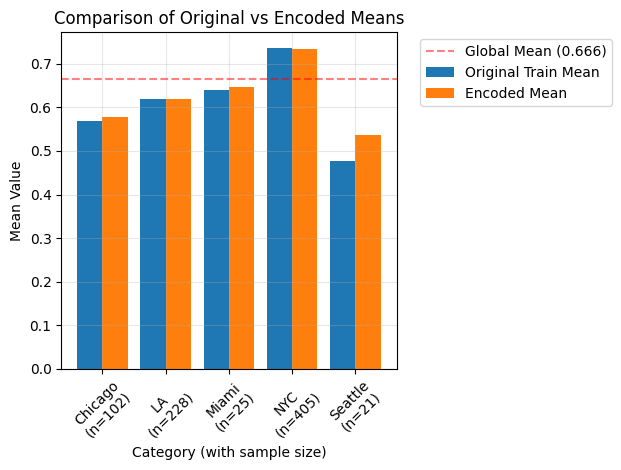

In [137]:
# Calculate means and create comparison DataFrame
results = pd.DataFrame({
    # 'Total Category Mean': target.groupby(data['city']).mean(),
    'Original Train Mean': y_train.groupby(X_train['city']).mean(),
    'Encoded Mean': X_train_processed.groupby(X_train['city'])['city'].mean()
})

# Add sample sizes for reference
category_sizes = X_train['city'].value_counts().sort_index()
global_mean = y_train.mean()

# Create bar plot
plt.figure(figsize=(12, 6))
results.plot(kind='bar', width=0.8)

# Add horizontal line for global mean
plt.axhline(y=global_mean, color='r', linestyle='--', alpha=0.5, 
            label=f'Global Mean ({global_mean:.3f})')

plt.title('Comparison of Original vs Encoded Means')
plt.xlabel('Category (with sample size)')
plt.ylabel('Mean Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add sample sizes to x-labels
plt.xticks(range(len(category_sizes)), 
           [f'{cat}\n(n={size})' for cat, size in category_sizes.items()], 
           rotation=45)

plt.tight_layout()
plt.show()

## Compare Smoothing Strategies

The sklearn TargetEncoder that is incorporated into the PreProcessor offers two main smoothing strategies:

1. 'auto' - Automatically determines the smoothing parameter based on the dataset characteristics
2. Custom float value - Manually specify the smoothing strength (higher values = more smoothing)

The `plot_target_encoding_comparison` function below visualizes how different smoothing parameters affect the encoded values. The visualization helps understand how smoothing balances between the raw category means and the global mean, particularly for categories with few samples where overfitting is a concern.

In [138]:
def plot_target_encoding_comparison(X_train, y_train, smooth_params, 
                                  target_col, figsize=(15, 6)):
    """
    Plot target encoding comparison with different smoothing parameters.
    
    Parameters:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): Target variable
        smooth_params (List[Union[str, float]]): List of smoothing parameters to compare
        target_col (str): Column name for target encoding (default='city')
        figsize (tuple): Figure size (default=(15, 6))
    
    Returns:
        dict: Dictionary containing the results for each smoothing parameter
    """
    # Create subplots
    fig, axes = plt.subplots(1, len(smooth_params), figsize=figsize)
    if len(smooth_params) == 1:
        axes = [axes]
    
    results_dict = {}
    global_mean = y_train.mean()
    
    # Create plots for each smoothing parameter
    for ax, smooth in zip(axes, smooth_params):
        # Initialize and fit preprocessor
        preprocessor = PreProcessor(
            num_impute_strategy='median',
            cat_impute_strategy='most_frequent',
            target_encode_cols=[target_col],
            target_encode_smooth=smooth
        )
        X_processed = preprocessor.fit_transform(X_train, y_train)
        
        # Calculate statistics
        results = pd.DataFrame({
            'Original_Train_Mean': y_train.groupby(X_train[target_col], observed=False).mean(),
            'Encoded_Mean': X_processed.groupby(X_train[target_col],observed=False)[target_col].mean(),
            'Sample_Size': X_train[target_col].value_counts()
        }).sort_index()
        
        results_dict[smooth] = results
        
        # Create bar plot
        results[['Original_Train_Mean', 'Encoded_Mean']].plot(kind='bar', width=0.8, ax=ax)
        ax.axhline(y=global_mean, color='r', linestyle='--', alpha=0.5,
                   label=f'Global Mean ({global_mean:.3f})')
        
        # Set title and labels
        smooth_label = 'auto' if smooth == 'auto' else str(smooth)
        ax.set_title(f'smooth={smooth_label}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Mean Value')
        
        # Add sample sizes to x-labels
        ax.set_xticks(range(len(results)))
        ax.set_xticklabels([f'{idx}\n(n={results["Sample_Size"][idx]})' 
                           for idx in results.index], 
                          rotation=45)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_dict


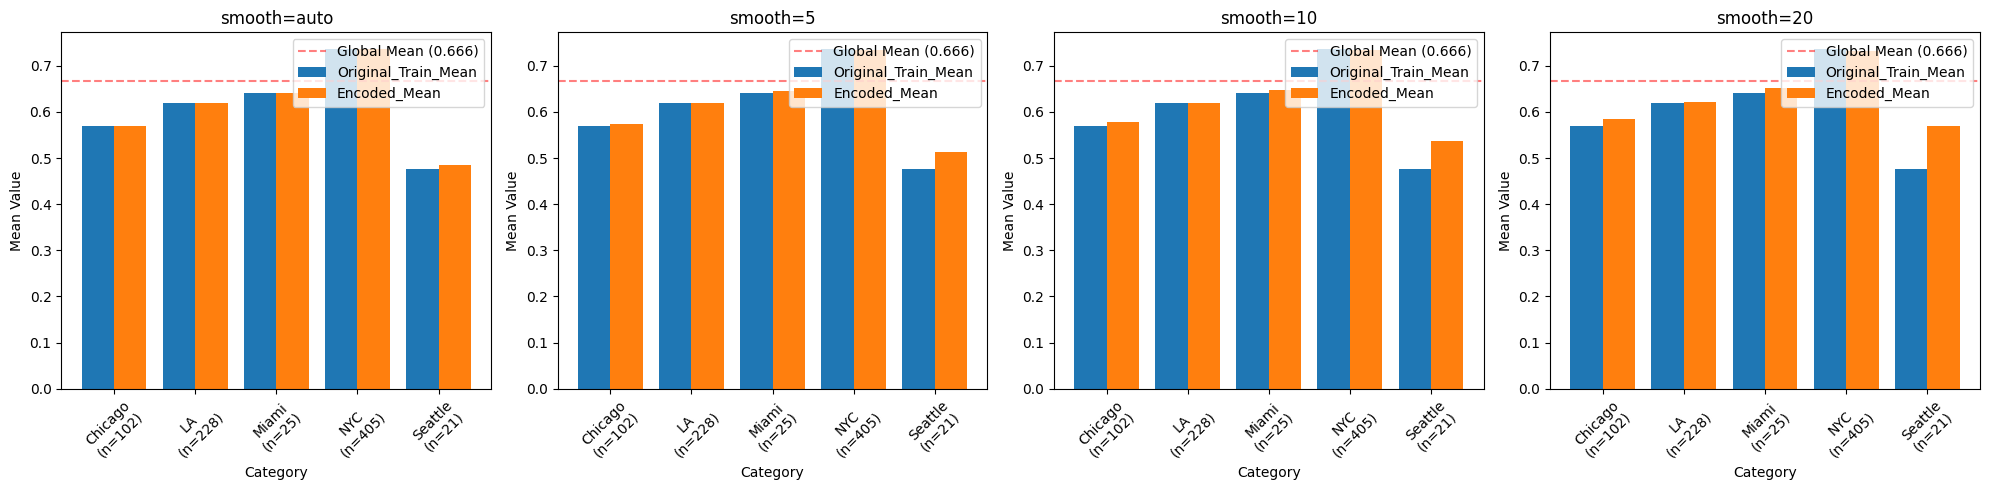

In [139]:
results = plot_target_encoding_comparison(X_train, y_train, 
                                        target_col= 'city',  
                                        smooth_params=['auto', 5, 10, 20],
                                        figsize=(20, 5))

# Incorporating into ML Pipeline

To support the user select the optimal smoothing parameter, we incorporated some viusalization into the PreProcessor class. They can be added as static methods, which means they can be called without instantiating the class. Pls see the updated class and demo below.


In [140]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer for data preprocessing.
    
    - Scales numeric features
    - Encodes categorical features
    - Handles missing values via imputation
    - Compatible with scikit-learn pipeline
    
    Attributes:
        num_impute_strategy (str): Numeric imputation strategy
        cat_impute_strategy (str): Categorical imputation strategy
        num_transformer (Pipeline): Numeric preprocessing pipeline
        cat_transformer (Pipeline): Categorical preprocessing pipeline
        target_encoder (TargetEncoder): Sklearn target encoder for mean encoding
        transformed_cat_cols (List[str]): One-hot encoded column names
        num_features (List[str]): Numeric feature names
        cat_features (List[str]): Categorical feature names
        target_encode_cols (List[str]): Columns for target encoding
        target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding
    """

    def __init__(self, num_impute_strategy='median', 
                 cat_impute_strategy='most_frequent',
                 target_encode_cols=None,
                 target_encode_smooth='auto'):
        """
        Initialize the transformer.
        
        - Sets up numeric data transformer
        - Sets up categorical data transformer
        - Configures imputation strategies

        
        Parameters:
            num_impute_strategy (str): Strategy for numeric missing values
            cat_impute_strategy (str): Strategy for categorical missing values
            target_encode_cols (List[str]): Columns to apply mean encoding
            target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding,
                                                      'auto' or float value (default='auto')
        """
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy
        self.target_encode_cols = target_encode_cols
        self.target_encode_smooth = target_encode_smooth

    def fit(self, X, y=None):
        """
        Fit transformer on input data.
        
        - Identifies feature types
        - Configures feature scaling
        - Sets up encoding
        - Fits imputation strategies
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            CustomTransformer: Fitted transformer
        """
        if self.target_encode_cols and y is None:
            raise ValueError("Target variable y is required when target_encode_cols is specified")
        
        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = [col for col in X.select_dtypes(exclude=np.number).columns 
                             if col not in (self.target_encode_cols or [])]
        
        if self.target_encode_cols:
            missing_cols = [col for col in self.target_encode_cols if col not in X.columns]
            if missing_cols:
                raise ValueError(f"Columns {missing_cols} not found in input data")
        
        # Handle mean encoding features
        if self.target_encode_cols:
            self.target_encoder = TargetEncoder(
                smooth=self.target_encode_smooth,
                cv=5
            )
            mean_encode_features = [f for f in self.target_encode_cols if f in X.columns]
            if mean_encode_features:
                self.target_encoder.fit(X[mean_encode_features], y)

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy)),
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Get transformed categorical column names.
        
        - Creates names after one-hot encoding
        - Combines category with encoded values
        
        Returns:
            List[str]: One-hot encoded column names
        """
        if not hasattr(self, 'cat_transformer'):
            return []
        
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transform input data.
        
        - Applies fitted scaling
        - Applies fitted encoding
        - Handles numeric and categorical features
        
        Parameters:
            X (pd.DataFrame): Input features
        
        Returns:
            pd.DataFrame: Transformed data
        """
        if not hasattr(self, 'num_features'):
            raise ValueError("Transformer not fitted. Call 'fit' before 'transform'.")
        
        X_transformed = pd.DataFrame()

        if self.target_encode_cols and hasattr(self, 'target_encoder'):
            mean_encoded_features = self.target_encoder.transform(X[self.target_encode_cols])
            mean_encoded_df = pd.DataFrame(
                mean_encoded_features, 
                columns=self.target_encode_cols,
            )
            X_transformed = pd.concat([X_transformed, mean_encoded_df], axis=1)

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols)
            X_transformed = pd.concat([X_transformed, transformed_cat_df], axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fit and transform input data.
        
        - Fits transformer to data
        - Applies transformation
        - Combines both operations
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            pd.DataFrame: Transformed data
        """
        self.fit(X, y)
        return self.transform(X)
    
    @staticmethod
    def plot_target_encoding_comparison(X_train, y_train, smooth_params, 
                                  target_col, figsize=(15, 6)):
        """
        Plot target encoding comparison with different smoothing parameters.
        
        Parameters:
            X_train (pd.DataFrame): Training features
            y_train (pd.Series): Target variable
            smooth_params (List[Union[str, float]]): List of smoothing parameters to compare
            target_col (str): Column name for target encoding (default='city')
            figsize (tuple): Figure size (default=(15, 6))
        
        Returns:
            dict: Dictionary containing the results for each smoothing parameter
        """
        # Create subplots
        fig, axes = plt.subplots(1, len(smooth_params), figsize=figsize)
        if len(smooth_params) == 1:
            axes = [axes]
        
        results_dict = {}
        global_mean = y_train.mean()
        
        # Create plots for each smoothing parameter
        for ax, smooth in zip(axes, smooth_params):
            # Initialize and fit preprocessor
            preprocessor = PreProcessor(
                num_impute_strategy='median',
                cat_impute_strategy='most_frequent',
                target_encode_cols=[target_col],
                target_encode_smooth=smooth
            )
            X_processed = preprocessor.fit_transform(X_train, y_train)
            
            # Calculate statistics
            results = pd.DataFrame({
                'Original_Train_Mean': y_train.groupby(X_train[target_col], observed=False).mean(),
                'Encoded_Mean': X_processed.groupby(X_train[target_col],observed=False)[target_col].mean(),
                'Sample_Size': X_train[target_col].value_counts()
            }).sort_index()
            
            results_dict[smooth] = results
            
            # Create bar plot
            results[['Original_Train_Mean', 'Encoded_Mean']].plot(kind='bar', width=0.8, ax=ax)
            ax.axhline(y=global_mean, color='r', linestyle='--', alpha=0.5,
                    label=f'Global Mean ({global_mean:.3f})')
            
            # Set title and labels
            smooth_label = 'auto' if smooth == 'auto' else str(smooth)
            ax.set_title(f'smooth={smooth_label}')
            ax.set_xlabel('Category')
            ax.set_ylabel('Mean Value')
            
            # Add sample sizes to x-labels
            ax.set_xticks(range(len(results)))
            ax.set_xticklabels([f'{idx}\n(n={results["Sample_Size"][idx]})' 
                            for idx in results.index], 
                            rotation=45)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        return results_dict
    
    @staticmethod
    def recommend_smoothing(X, target_col, min_samples=50):
        """
        Recommend smoothing parameter based on dataset characteristics
        This is a preliminary first iteration and can be improved.
        
        Parameters:
            X (pd.DataFrame): Input features
            target_col (str): Column to encode
            min_samples (int): Minimum samples for reliable estimation
        
        Returns:
            Union[str, float]: Recommended smoothing parameter
        """
        category_counts = X[target_col].value_counts()
        rare_categories = (category_counts < min_samples).sum()
        total_categories = len(category_counts)
        
        rare_ratio = rare_categories / total_categories
        
        if rare_ratio > 0.3:
            print(f"\nRecommending strong smoothing (20) because {rare_ratio:.1%} of categories are rare")
            print(f"- {rare_categories} out of {total_categories} categories have fewer than {min_samples} samples")
            return 20
        elif rare_ratio > 0.1:
            print(f"\nRecommending moderate smoothing (10) because {rare_ratio:.1%} of categories are rare")
            print(f"- {rare_categories} out of {total_categories} categories have fewer than {min_samples} samples")
            return 10
        else:
            print(f"\nRecommending 'auto' smoothing because only {rare_ratio:.1%} of categories are rare")
            print(f"- Only {rare_categories} out of {total_categories} categories have fewer than {min_samples} samples")
            return 'auto'
    
    @staticmethod
    def identify_high_cardinality_columns(df: pd.DataFrame, threshold: int = 10) -> dict:
        """
        Identifies categorical columns with unique values exceeding the threshold.
        
        Parameters:
            df (pd.DataFrame): Input DataFrame
            threshold (int): Number of unique values above which a column is considered 
                            high cardinality (default: 10)
        
        Returns:
            dict: Dictionary containing:
                - 'high_cardinality': List of high cardinality columns
                - 'analysis': DataFrame showing number of unique values for each categorical column
        """
        # Get categorical columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        
        if len(categorical_cols) == 0:
            print("No categorical columns found in the dataset.")
            return {'high_cardinality': [], 'analysis': pd.DataFrame()}
        
        # Calculate unique values for each column
        analysis_data = []
        high_cardinality_cols = []
        
        for col in categorical_cols:
            n_unique = df[col].nunique()
            analysis_data.append({
                'column': col,
                'unique_values': n_unique
            })
            
            if n_unique > threshold:
                high_cardinality_cols.append(col)
        
        # Create analysis DataFrame
        analysis_df = pd.DataFrame(analysis_data).sort_values('unique_values', ascending=False)
        
        # Print summary
        print(f"\nColumns with more than {threshold} unique values as candidate(s) for target encoding:")
        if high_cardinality_cols:
            print(analysis_df[analysis_df['unique_values'] > threshold])
        else:
            print("None found, proceed without target encoding.")  


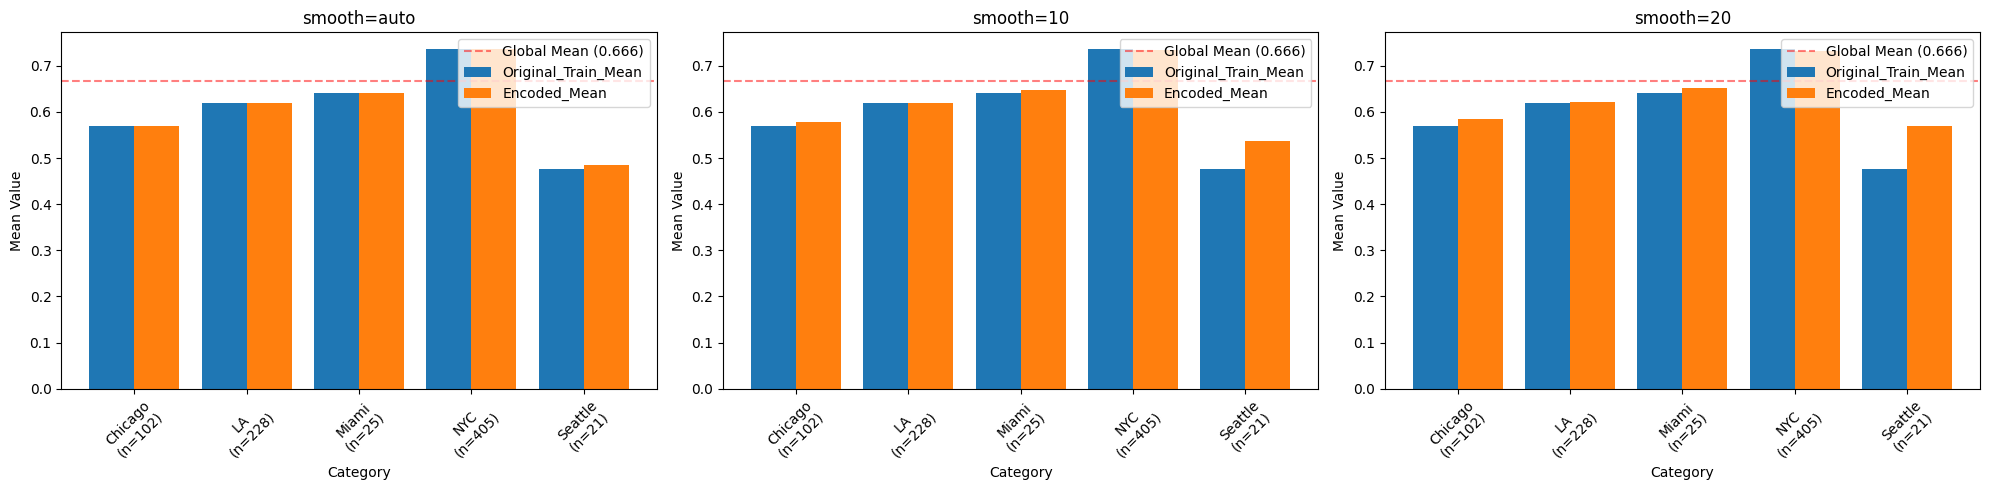

In [141]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_col= 'city',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))


In [142]:
recommendations = PreProcessor.recommend_smoothing(X_train, 'city')
print(f"recommended smoothing parameter: {recommendations}")


Recommending strong smoothing (20) because 40.0% of categories are rare
- 2 out of 5 categories have fewer than 50 samples
recommended smoothing parameter: 20


# Integration into ML_Pipeline

In [180]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    Custom ML pipeline for classification and regression.
    
    - Works with scikit-learn compatible models
    - Handles data preprocessing
    - Manages model training and predictions
    - Provide global and local model explanation
    - Compatible with MLflow tracking
    - Supports MLflow deployment

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance
        preprocessor (Any or None): Data preprocessing pipeline
        config (Any or None): Optional config for model settings 
        task(str): Type of ML task ('classification' or 'regression')
        n_features (int): Number of features after preprocessing
        both_class (bool): Whether SHAP values include both classes
        shap_values (shap.Explanation): SHAP values for model explanation
        X_explain (pd.DataFrame): Processed features for SHAP explanation
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config = None):
        """
        Initialize the ML_PIPELINE with an optional model, preprocessor, and configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model, such as LightGBM 
                or XGBoost, for training and predictions. Defaults to None.
            preprocessor (Any, optional): A transformer or pipeline used to preprocess the input 
                data. Defaults to None.
            config (Any, optional): Additional configuration settings for the model, if needed. 
                Defaults to None.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config
        self.task = "classification" if hasattr(self.model, "predict_proba") else "regression"
        self.shap_values = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series,
            eval_set=None, early_stopping_rounds=None):
        """
        Train the model using the provided training data, after applying preprocessing.

        Parameters:
            X_train (pd.DataFrame): A DataFrame containing feature columns for training.
            y_train (pd.Series): A Series containing the target variable values.
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy(), y_train.copy())
        self.n_features = X_train_preprocessed.shape[1]
        
        # Prepare fit parameters
        fit_params = {}
        if eval_set is not None:
            X_val, y_val = eval_set
            X_val_transformed = self.preprocessor.transform(X_val)
            fit_params['eval_set'] = [(X_val_transformed, y_val)]
            
            if early_stopping_rounds is not None:
                fit_params['early_stopping_rounds'] = early_stopping_rounds

        self.model.fit(X_train_preprocessed, y_train, **fit_params)

    def predict(
            self, context: Any, model_input: pd.DataFrame
            ) -> np.ndarray:
        """
        Make predictions using the pre-trained model, applying preprocessing to the input data.

        Parameters:
            context (Any): Optional context information provided by MLflow during the 
                prediction phase.
            model_input (pd.DataFrame): The DataFrame containing input features for predictions.

        Returns:
            Any: A NumPy array or DataFrame with the predicted probabilities or output values.
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        if self.task == "classification":
            prediction = self.model.predict_proba(processed_model_input)[:,1]
        elif self.task == "regression":
            prediction = self.model.predict(processed_model_input)
        return prediction
    
    def explain_model(self,X):
        """
        Generate SHAP values and plots for model interpretation.
        
        This method:
        1. Transforms the input data using the fitted preprocessor
        2. Creates a SHAP explainer appropriate for the model type
        3. Calculates SHAP values for feature importance
        4. Generates a summary plot of feature importance
        
        Parameters:
            X : pd.DataFrame
                Input features to generate explanations for. Should have the same 
                columns as the training data.
        
        Returns: None
            The method stores the following attributes in the class:
            - self.X_explain : pd.DataFrame
                Transformed data with original numeric values for interpretation
            - self.shap_values : shap.Explanation
                SHAP values for each prediction
            - self.both_class : bool
                Whether the model outputs probabilities for both classes          
        """
        X_transformed = self.preprocessor.transform(X.copy())
        self.X_explain = X_transformed.copy()
        # get pre-transformed values for numeric features
        self.X_explain[self.preprocessor.num_features] = X[self.preprocessor.num_features]
        self.X_explain.reset_index(drop=True)
        try:
            # Attempt to create an explainer that directly supports the model
            explainer = shap.Explainer(self.model)
        except:
            # Fallback for models or shap versions where direct support may be limited
            explainer = shap.Explainer(self.model.predict, X_transformed)
        self.shap_values = explainer(X_transformed)  

        # get the shape of shap values and extract accordingly
        self.both_class = len(self.shap_values.values.shape) == 3
        if self.both_class:
            shap.summary_plot(self.shap_values[:,:,1])
        elif self.both_class == False:
            shap.summary_plot(self.shap_values)
    
    def explain_case(self,n):
        """
        Generate SHAP waterfall plot for one specific case.
        
        - Shows feature contributions
        - Starts from base value
        - Ends at final prediction
        - Shows original feature values for better interpretability
        
        Parameters:
            n (int): Case index (1-based)
                     e.g., n=1 explains the first case.
        
        Returns:
            None: Displays SHAP waterfall plot
        
        Notes:
            - Requires explain_model() first
            - Shows positive class for binary tasks
        """
        if self.shap_values is None:
            print("""
                  Please explain model first by running
                  `explain_model()` using a selected dataset
                  """)
        else:
            self.shap_values.data = self.X_explain
            if self.both_class:
                shap.plots.waterfall(self.shap_values[:,:,1][n-1])
            elif self.both_class == False:
                shap.plots.waterfall(self.shap_values[n-1]) 

    def _evaluate_regression_model(self, y_true, y_pred, verbose: bool = False):
        """
        Calculate multiple regression metrics for better interpretability.
        
        Parameters:
            y_true: True target values
            y_pred: Predicted target values
            verbose: If True, prints detailed evaluation metrics and analysis.
                    If False, returns metrics without printing (default=False)
        
        Returns:
            dict: Dictionary of different metrics
        """
        from sklearn.metrics import mean_squared_error, r2_score
        import numpy as np
        
        # Basic metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - self.n_features - 1)
        
        # Scale-independent metrics: mean absolute percentage error
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  
        
        # Normalized RMSE 
        nrmse = rmse / np.mean(y_true) * 100
        
        # Compare to baseline (using mean)
        baseline_pred = np.full_like(y_true, np.mean(y_true))
        baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_pred))
        rmse_improvement = (baseline_rmse - rmse) / baseline_rmse * 100

        if verbose:         
            print("\nRegression Model Evaluation:")
            print("-" * 40)
            print(f"RMSE: {rmse:.3f}")
            print(f"Normalized RMSE: {nrmse:.1f}% of target mean")
            print(f"MAPE: {mape:.1f}%")
            print(f"R² Score: {r2:.3f}")
            print(f"Adjusted R² Score: {adj_r2:.3f}")
            print(f"Improvement over baseline: {rmse_improvement:.1f}%")
            if r2 - adj_r2 > 0.1:
                print("\nWarning: Large difference between R² and Adjusted R² suggests possible overfitting")
                print(f"- R² dropped by {(r2 - adj_r2):.3f} after adjustment")
                print("- Consider feature selection or regularization")
        
        return {
            'rmse': rmse,
            'nrmse': nrmse,
            'mape': mape,
            'r2': r2,
            'improvement': rmse_improvement
        }
    
    def _evaluate_classification_model(self, y_true: pd.Series, y_pred_proba: np.ndarray, 
                           default_threshold: float = 0.5, beta: float = 1.0,
                           verbose: bool = False):
        """
        Calculate classification metrics with threshold analysis.
        
        Parameters:
            y_true: True target values
            y_pred_proba: Predicted probabilities
            default_threshold: Default classification threshold (default=0.5)
            beta: Beta value for F-beta score optimization (default=1.0)
                beta > 1 gives more weight to recall
                beta < 1 gives more weight to precision
            verbose: If True, prints detailed evaluation metrics and analysis.
                     If False, returns metrics without printing (default=False)
        
        Returns:
            dict: Dictionary containing metrics and threshold analysis
        """
        from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                                f1_score, roc_auc_score, confusion_matrix,
                                precision_recall_curve, roc_curve)
        import numpy as np
        
        # Get predictions at specified threshold
        y_pred = (y_pred_proba >= default_threshold).astype(int)
                
        # Core metrics at specified threshold
        metrics_default = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f_beta': fbeta_score(y_true, y_pred, beta=beta),
            'auc_roc': roc_auc_score(y_true, y_pred_proba)
        }
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate curves for threshold analysis
        precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
        
        # Find optimal threshold based on F-beta score
        # F-beta = (1 + beta^2) * (precision * recall) / (beta^2 * precision + recall)
        f_beta_scores = ((1 + beta**2) * (precisions * recalls) / 
                        (beta**2 * precisions + recalls + 1e-10))
        optimal_threshold_idx = np.argmax(f_beta_scores)
        optimal_threshold = pr_thresholds[optimal_threshold_idx] if len(pr_thresholds) > optimal_threshold_idx else default_threshold

        # Calculate metrics at optimal threshold
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        metrics_optimal = {
            'accuracy': accuracy_score(y_true, y_pred_optimal),
            'precision': precision_score(y_true, y_pred_optimal),
            'recall': recall_score(y_true, y_pred_optimal),
            'f1': f1_score(y_true, y_pred_optimal),
            'f_beta': fbeta_score(y_true, y_pred_optimal, beta=beta),
            'threshold': optimal_threshold
        }
        
        if verbose: 
            # Print comprehensive report
            print("\nClassification Metrics Report")
            print("=" * 50)
            
            print(f"\nClassification threshold ({default_threshold:.3f}):")
            print(f"Accuracy:  {metrics_default['accuracy']:.3f}")
            print(f"F1:        {metrics_default['f1']:.3f}")
            if beta != 1:
                print(f"F_beta:    {metrics_default['f_beta']:.3f}")
            print(f"Precision: {metrics_default['precision']:.3f}")
            print(f"Recall:    {metrics_default['recall']:.3f}")
        
        # if beta != 1:
        #     print(f"\nThreshold optimizing f_{beta}: ({optimal_threshold:.3f}):")
        # else:
        #     print(f"\nThreshold optimizing f1: ({optimal_threshold:.3f}):")
            
        # print(f"Accuracy:  {metrics_optimal['accuracy']:.3f}")
        # print(f"F1:        {metrics_optimal['f1']:.3f}")
        # if beta != 1:
        #     print(f"F_beta:    {metrics_optimal['f_beta']:.3f}")
        # print(f"Precision: {metrics_optimal['precision']:.3f}")
        # print(f"Recall:    {metrics_optimal['recall']:.3f}")
        
            print(f"\nAUC which is threshold independent:")
            print(f"AUC-ROC:   {metrics_default['auc_roc']:.3f}") 
        
        return {
            'metrics': {
                'default': metrics_default,
                'optimal': metrics_optimal,
                'auc': metrics_default['auc_roc']  
            },
            'threshold_analysis': {
                'current_threshold': default_threshold,
                'optimal_threshold': optimal_threshold,
                'precision_recall_curve': {
                    'precisions': precisions,
                    'recalls': recalls,
                    'thresholds': pr_thresholds
                },
                'roc_curve': {
                    'fpr': fpr,
                    'tpr': tpr,
                    'thresholds': roc_thresholds
                }
            }
        }
    
    def evaluate(self, X_test: pd.DataFrame, y_test: pd.Series, 
                default_threshold: float = 0.5, beta: float = 1.0,
                verbose: bool = False):
        """
        Evaluate model performance using appropriate metrics based on the task.        
        
        Parameters:
            X_test: Test features DataFrame
            y_test: True target values
            default_threshold: Classification threshold for binary predictions (default=0.5)
            beta: Beta value for F-beta score calculation (default=1.0)
            verbose: If True, prints detailed evaluation metrics and analysis.
                    If False, returns metrics without printing (default=False)
        
        Returns:
            dict: Dictionary containing evaluation metrics
        """
        if self.task == "classification":
            y_pred_proba = self.predict(context=None, model_input=X_test)
            return self._evaluate_classification_model(y_test, y_pred_proba, default_threshold, beta, verbose=verbose)
        else:  # regression
            y_pred = self.predict(context=None, model_input=X_test)
            return self._evaluate_regression_model(y_test, y_pred,verbose=verbose)
        
    
    @staticmethod
    def tune(X, y, algorithm, space, max_evals=500, random_state=42, beta=1, early_stopping_rounds=100, verbose=0):
        """
        Static method to tune hyperparameters using AUC and find optimal threshold.
        
        Parameters:
            X: Features
            y: Target
            algorithm: ML algorithm class (e.g., lgb.LGBMClassifier)
            space: Hyperopt parameter search space
            max_evals: Maximum number of evaluations
            random_state: Random seed for reproducibility
            beta: Beta value for F-beta score optimization (default=1.0)
                beta > 1 gives more weight to recall
                beta < 1 gives more weight to precision
            early_stopping_rounds: Stop tuning if no improvement in specified number of trials
                
        Returns:
            dict: Contains:
                - best_params: Best hyperparameters found
        """

        # Split train+val into train and val
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
        # Split train+val into train and val
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_SEED)

        def objective(params):                  
            model = ML_PIPELINE(
                model=algorithm(**params, verbose=verbose),
                preprocessor=PreProcessor()
            )
            
            # Fit and evaluate using AUC
            model.fit(X_train, y_train)
            results = model.evaluate(X_val, y_val)
            auc_score = results['metrics']['auc']
            
            return {'loss': -auc_score, 'status': STATUS_OK}
        
        # Run optimization
        trials = Trials()
        def early_stop_fn(trials, *args):
            if len(trials.trials) < early_stopping_rounds:
                return (False, "Not enough trials")            
            scores = [-trial['result']['loss'] for trial in trials.trials[-early_stopping_rounds:]]
            
            if len(scores) >= early_stopping_rounds and max(scores) == scores[0]:
                return (True, f"No improvement in last {early_stopping_rounds} trials")
            else:
                return (False, "Continuing optimization")
        
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            early_stop_fn=early_stop_fn
        )
        
        # Get best parameters and create best pipeline
        best_params = space_eval(space, best)
        best_pipeline = ML_PIPELINE(
            model=algorithm(**best_params, verbose=verbose),
            preprocessor=PreProcessor()
        )
        
        # Train final model with best parameters on full training set
        final_model = ML_PIPELINE(
            model = algorithm(**best_params, verbose=verbose),
            preprocessor = PreProcessor()
        )
        X_train_full = pd.concat([X_train, X_val])
        y_train_full = pd.concat([y_train, y_val])
        final_model.fit(X_train_full, y_train_full)
        temp = final_model.evaluate(X_train_full, y_train_full, beta=beta)
        optimal_threshold = temp['threshold_analysis']['optimal_threshold']
        
        # Print results on new data
        final_results = final_model.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True)
        print("\nHyperparameter Tuning Results")
        print("=" * 50)
        print(f"\nBest parameters found:")
        for param, value in best_params.items():
            print(f"{param}: {value}")
        
        return {
            'best_params': best_params,
            'best_pipeline': final_model,
            'trials': trials,
            'beta for Fbeta': beta,
            'optimal_threshold to maximize Fbeta': optimal_threshold,
            'test_auc': final_results['metrics']['auc'], 
            'test_Fbeta': final_results['metrics']['default']['f_beta'],
            'test_precision': final_results['metrics']['default']['precision'],
            'test_recall': final_results['metrics']['default']['recall'],
        }


# Modeling Demo

## Regression Problem

In [181]:
# Load California Housing dataset, which has no categorical features
housing = fetch_california_housing(as_frame=True)
X = housing.data
y = housing.target

# Create a neighborhood feature based on location which has high cardinality
neighborhoods = (
        pd.qcut(X['Longitude'], q=5).astype(str) + '_' + 
        pd.qcut(X['Latitude'], q=5).astype(str)
    )
unique_neighborhoods = neighborhoods.unique()
readable_names = [f'District_{i+1}' for i in range(len(unique_neighborhoods))]
name_mapping = dict(zip(unique_neighborhoods, readable_names))    
X['Neighborhood'] = neighborhoods.map(name_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [182]:
# Identify Target Encoding Columns and Select Smoothing Parameter
PreProcessor.identify_high_cardinality_columns(X_train, 10)


Columns with more than 10 unique values as candidate(s) for target encoding:
         column  unique_values
0  Neighborhood             17


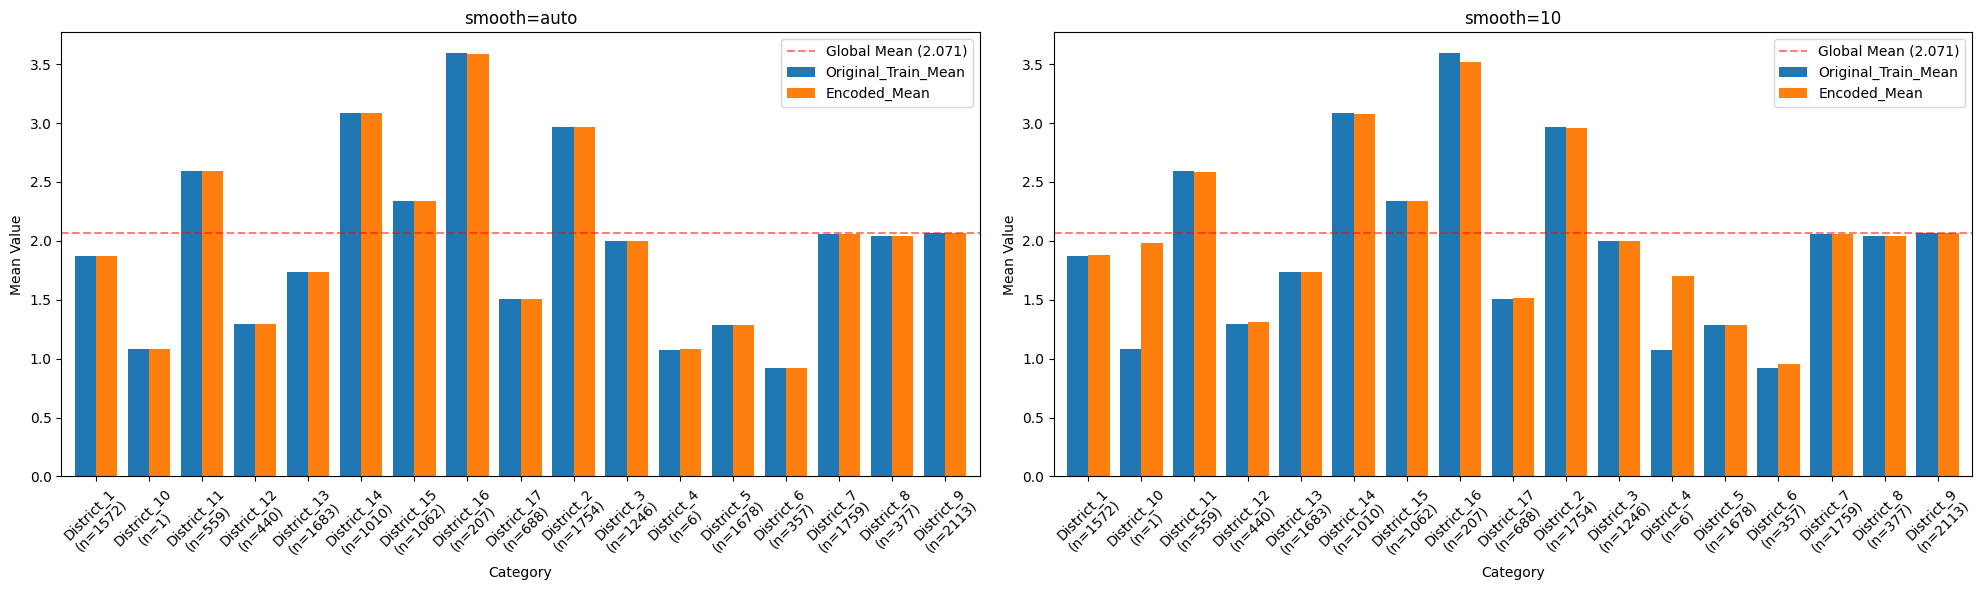

In [183]:
# there is one district with only 5 cases where smoothing will bring the encoded mean much closer to global mean
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train,
                                                       target_col= 'Neighborhood', smooth_params=['auto', 10],
                                                       figsize=(20,6))

In [184]:
# Define, Fit and Use the ML Pipeline
preprocessor = PreProcessor(target_encode_cols=['Neighborhood'], target_encode_smooth=10)

mlpipeline = ML_PIPELINE(
    model = lgb.LGBMRegressor(verbose=-1),
    preprocessor=preprocessor
)

In [185]:
mlpipeline.fit(X_train, y_train)
y_pred = mlpipeline.predict(model_input = X_test, context=None)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"rmse:{rmse:.2f}")

rmse:0.47


In [186]:
# automatically produce evaluation report on main metrics
metrics = mlpipeline.evaluate(X_test, y_test)

In [187]:
# Easily retrive any particular metric
metrics['rmse']

0.4669376792506235

## Classification Problem

In [188]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Train and Use the ml pipeline
PreProcessor.identify_high_cardinality_columns(X_train)
mlpipeline = ML_PIPELINE(
    model=lgb.LGBMClassifier(
        random_state=42,
        verbose = -1,
        n_estimators=1000,
        early_stopping_round = 100,
        min_child_samples=20,
        scale_pos_weight=1.74
        ),
    preprocessor=PreProcessor()
)
mlpipeline.fit(X_train, 
               y_train,
               eval_set=(X_val, y_val)
               )


Columns with more than 10 unique values as candidate(s) for target encoding:
None found, proceed without target encoding.


In [189]:
# Summary evaluation report
results = mlpipeline.evaluate(X_test, y_test, beta=0.8, verbose=True)


Classification Metrics Report

Classification threshold (0.500):
Accuracy:  0.798
F1:        0.773
F_beta:    0.775
Precision: 0.783
Recall:    0.763

AUC which is threshold independent:
AUC-ROC:   0.846


In [190]:
# ROC Curve if of interest
results['threshold_analysis']['roc_curve']

{'fpr': array([0.        , 0.        , 0.        , 0.00694444, 0.00694444,
        0.01388889, 0.01388889, 0.02083333, 0.02083333, 0.02777778,
        0.02777778, 0.03472222, 0.03472222, 0.04861111, 0.04861111,
        0.05555556, 0.05555556, 0.06944444, 0.06944444, 0.07638889,
        0.07638889, 0.08333333, 0.08333333, 0.09027778, 0.09027778,
        0.09722222, 0.09722222, 0.11111111, 0.11111111, 0.11805556,
        0.13194444, 0.13194444, 0.13888889, 0.13888889, 0.14583333,
        0.15277778, 0.16666667, 0.16666667, 0.17361111, 0.17361111,
        0.18055556, 0.18055556, 0.20138889, 0.22916667, 0.22916667,
        0.25694444, 0.25694444, 0.26388889, 0.26388889, 0.27777778,
        0.29861111, 0.29861111, 0.3125    , 0.31944444, 0.34027778,
        0.34027778, 0.35416667, 0.35416667, 0.36805556, 0.36805556,
        0.41666667, 0.4375    , 0.44444444, 0.44444444, 0.45138889,
        0.47222222, 0.49305556, 0.51388889, 0.53472222, 0.56944444,
        0.57638889, 0.57638889, 0.6319444

# Hyperparameter Tuning


## Metrics for Hyperparameter Tuning

**AUC**
- AUC is a threshold-independent metric that focuses on the overall performance of the model across all possible threshold values.
- It is useful when you want to evaluate the model’s ability to distinguish between positive and negative instances without specifying a threshold.
- AUC-ROC is particularly useful in scenarios with imbalanced classes, a high AUC score means that the model ranks positive examples higher than negative ones, which is still meaningful even if one class dominates the dataset.
- AUC is often used in binary classification problems where the goal is to maximize the overall classification accuracy.

**F1**
- Requires defining a threshold (default = 0.5, which may not be optimal).
- It is useful when you want to optimize the trade-off between precision and recall for this specific threshold.
- It is sensitive to class imbalance (optimizes for the majority class if not weighted).
- In imbalanced data, precision, recall and F1 at a fixed threshold (like 0.5) can be misleading.

**Hybrid approach**
- Option A: Optimize AUC first, then tune thresholds: Use AUC for hyperparameter tuning, then adjust the threshold post-training based on F1 or Fbeta. This is a more robust approach as it focus on maximizing overall class separation and is threshold agnostic. 
- Option B: Alternatively, one can also optimizing F1 based on a fixed threshold (e.g., 0.5) first, then try to identify the optimal threshold later. But if the initial hyperparameters are already optimized for F1 at 0.5, adjusting the threshold might not yield as much improvement because the model is already focused on that point.    


| Aspect | F1-First Hybrid | AUC-First Hybrid |
|--------|----------------|------------------|
| Hyperparameter Goal | Maximize F1 at threshold = 0.5 | Maximize overall class separation (AUC) |
| Threshold Flexibility | Limited (hyperparams tuned for 0.5 threshold) | High (hyperparams agnostic to threshold) |
| Class Imbalance | May struggle if default threshold is biased | Robust (focuses on ranking, not fixed threshold) |
| Best Case Scenario | When default threshold aligns with optimal | When optimal threshold differs from default |
| Threshold Optimization | Fixed during hyperparameter tuning | Can be adjusted post-training to optimize any Fβ score based on business needs | 

## Hyperparameter tuning with ML Pipeline

In [191]:

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)


In [192]:
# Define the hyperparameter search space
space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 8)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

In [171]:
def tune(X, y, algorithm, space, max_evals=500, random_state=42, beta=1, early_stopping_rounds=100, verbose=0):
        """
        Static method to tune hyperparameters using AUC and find optimal threshold.
        
        Parameters:
            X: Features
            y: Target
            algorithm: ML algorithm class (e.g., lgb.LGBMClassifier)
            space: Hyperopt parameter search space
            max_evals: Maximum number of evaluations
            random_state: Random seed for reproducibility
            beta: Beta value for F-beta score optimization (default=1.0)
                beta > 1 gives more weight to recall
                beta < 1 gives more weight to precision
            early_stopping_rounds: Stop tuning if no improvement in specified number of trials
                
        Returns:
            dict: Contains:
                - best_params: Best hyperparameters found
        """

        # Split train+val into train and val
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
        # Split train+val into train and val
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_SEED)

        def objective(params):                  
            model = ML_PIPELINE(
                model=algorithm(**params, verbose=verbose),
                preprocessor=PreProcessor()
            )
            
            # Fit and evaluate using AUC
            model.fit(X_train, y_train)
            results = model.evaluate(X_val, y_val)
            auc_score = results['metrics']['auc']
            
            return {'loss': -auc_score, 'status': STATUS_OK}
        
        # Run optimization
        trials = Trials()
        def early_stop_fn(trials, *args):
            if len(trials.trials) < early_stopping_rounds:
                return (False, "Not enough trials")            
            scores = [-trial['result']['loss'] for trial in trials.trials[-early_stopping_rounds:]]
            
            if len(scores) >= early_stopping_rounds and max(scores) == scores[0]:
                return (True, f"No improvement in last {early_stopping_rounds} trials")
            else:
                return (False, "Continuing optimization")
        
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            early_stop_fn=early_stop_fn
        )
        
        # Get best parameters and create best pipeline
        best_params = space_eval(space, best)
        best_pipeline = ML_PIPELINE(
            model=algorithm(**best_params, verbose=verbose),
            preprocessor=PreProcessor()
        )
        
        # Train final model with best parameters on full training set
        final_model = ML_PIPELINE(
            model = algorithm(**best_params, verbose=verbose),
            preprocessor = PreProcessor()
        )
        X_train_full = pd.concat([X_train, X_val])
        y_train_full = pd.concat([y_train, y_val])
        final_model.fit(X_train_full, y_train_full)
        temp = final_model.evaluate(X_train_full, y_train_full, beta=beta)
        optimal_threshold = temp['threshold_analysis']['optimal_threshold']
        
        # Print results on new data
        final_results = final_model.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True)
        print("\nHyperparameter Tuning Results")
        print("=" * 50)
        print(f"\nBest parameters found:")
        for param, value in best_params.items():
            print(f"{param}: {value}")
        
        return {
            'best_params': best_params,
            'best_pipeline': final_model,
            'trials': trials,
            'beta for Fbeta': beta,
            'optimal_threshold to maximize Fbeta': optimal_threshold,
            'test_auc': final_results['metrics']['auc'], 
            'test_Fbeta': final_results['metrics']['default']['f_beta'],
            'test_precision': final_results['metrics']['default']['precision'],
            'test_recall': final_results['metrics']['default']['recall'],
        }

In [193]:
results = ML_PIPELINE.tune(X, y, algorithm=lgb.LGBMClassifier, space=space, verbose=-1)

 51%|█████     | 253/500 [00:43<00:42,  5.79trial/s, best loss: -0.8644240570846076]

Classification Metrics Report

Classification threshold (0.405):
Accuracy:  0.779
F1:        0.729
Precision: 0.812
Recall:    0.661

AUC which is threshold independent:
AUC-ROC:   0.864

Hyperparameter Tuning Results

Best parameters found:
colsample_bytree: 0.8938238002288216
learning_rate: 0.012589737256157587
max_depth: 10
min_child_weight: 5
n_estimators: 300
subsample: 0.667765023825426


### Swap Algorithm 

In [194]:
rf_space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [None, *range(5, 31, 5)]), 
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 7)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False])
}
results = ML_PIPELINE.tune(X, y, algorithm=RandomForestClassifier, space=rf_space, beta = 1)

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

 49%|████▊     | 243/500 [02:09<02:16,  1.88trial/s, best loss: -0.865143610961204] 

Classification Metrics Report

Classification threshold (0.305):
Accuracy:  0.794
F1:        0.771
Precision: 0.771
Recall:    0.771

AUC which is threshold independent:
AUC-ROC:   0.876

Hyperparameter Tuning Results

Best parameters found:
bootstrap: True
max_depth: None
max_features: None
min_samples_leaf: 6
min_samples_split: 2
n_estimators: 100


# Next Steps

1. ~~add early_stop, eval_set to ml_pipeline~~
2. ~~use the metrics returned for hyperparameter tuning (iterative tuning)~~
3. ~~add a classification problem~~
4. ~~add and test early_stopping in tunning~~
5. ~~provide a hyperpamameter tuning method to ML pipeline, which allows user to specify space, beta, early_stopping, etc~~
6. ~~change the evaluate method, with the optimal threshold provided~~
7. offer demo to compare the auc-first vs f1-first approach for tunning
8. add f1-first option in case necessary
9. add a function to log the best ml pipeline

